In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
from torchvision import datasets, transforms
from torchvision.models import resnet50
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
import glob
import time
import pandas as pd
import torch.optim as optim
from IPython import display
import torchvision.models as tv_models
#%%
class MyDataset(torch_dataset):
    def __init__(self, path, filenamelist, labellist):
        self.path=path
        self.filenamelist=filenamelist
        self.labellist=labellist
    def __len__(self):
        #return the number of data points
        return len(self.filenamelist)
    def __getitem__(self, idx):
        I=io.imread(self.path+self.filenamelist[idx])
        I=skimage.util.img_as_float32(I)
        I = I.reshape(1,I.shape[0],I.shape[1])
        I = torch.tensor(I, dtype=torch.float32)
        I = I.expand(3, I.shape[1],I.shape[2])
        label=torch.tensor(self.labellist[idx], dtype=torch.int64)
        return I, label
#%%
def get_dataloader():
    df_train=pd.read_csv('/Users/bhuvanavenkatappa/Documents/ML notes/hw5s-2/S224/train.csv')
    path='/Users/bhuvanavenkatappa/Documents/ML notes/hw5s-2/S224/'
    dataset_train = MyDataset(path, df_train['filename'].values, df_train['label'].values)
    loader_train = torch_dataloader(dataset_train, batch_size=32, num_workers=0,
                                    shuffle=True, pin_memory=True)
    return dataset_train, loader_train

def get_dataloader1():
    df_train=pd.read_csv('/Users/bhuvanavenkatappa/Documents/ML notes/hw5s-2/S224/test.csv')
    path='/Users/bhuvanavenkatappa/Documents/ML notes/hw5s-2/S224/'
    dataset_test = MyDataset(path, df_train['filename'].values, df_train['label'].values)
    loader_test = torch_dataloader(dataset_test, batch_size=32, num_workers=0,
                                    shuffle=True, pin_memory=True)
    return dataset_test, loader_test

def get_dataloader2():
    df_train=pd.read_csv('/Users/bhuvanavenkatappa/Documents/ML notes/hw5s-2/S224/val.csv')
    path='/Users/bhuvanavenkatappa/Documents/ML notes/hw5s-2/S224/'
    dataset_val = MyDataset(path, df_train['filename'].values, df_train['label'].values)
    loader_val = torch_dataloader(dataset_val, batch_size=32, num_workers=0,
                                    shuffle=True, pin_memory=True)
    return dataset_val, loader_val

In [30]:
import argparse
import cv2
import numpy as np
import torch
from torchvision import models
from pytorch_grad_cam import GradCAM, \
    HiResCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad, \
    GradCAMElementWise
from pytorch_grad_cam.utils.image import show_cam_on_image

In [5]:
dataset_train, loader_train = get_dataloader()

In [6]:
dataset_val, loader_val = get_dataloader2()

In [7]:
dataset_test, loader_test = get_dataloader1()

In [8]:
len(dataset_train)

2022

In [9]:
len(loader_train)

64

In [10]:
len(loader_val)

2

In [11]:
len(dataset_test)

400

In [12]:
len(dataset_val)

60

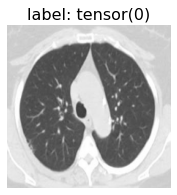

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, 10, 1):
    x = dataset_train[n][0].detach().cpu().numpy()
    y = dataset_train[n][1]
    x = x.transpose(1,2,0)
    ax.imshow(x)
    ax.set_title('label: ' + str(y), fontsize=16)
    ax.axis('off')
    display.clear_output(wait=False)
    display.display(fig)
    plt.pause(0.5)  

In [14]:
#model3
#transfer learning

from torchvision.models import ResNet50_Weights
class Net(nn.Module):
    def __init__(self):
        super().__init__()        
        #use resnet50 as the base model
        #self.resnet50 = tv_models.resnet50(pretrained=True) #old Pytorch
        self.resnet50 = tv_models.resnet50(weights=ResNet50_Weights.DEFAULT)
        #modified the last layer for binary classification  
        self.resnet50.fc=torch.nn.Linear(2048, 1)           
        #freeze all parameters
        for p in self.resnet50.parameters():
            p.requires_grad = False 
        #set the parameters of layer4 to be trainable       
        for p in self.resnet50.layer4.parameters():
            p.requires_grad = True       
        #set the parameters of fc to be trainable       
        for p in self.resnet50.fc.parameters():
            p.requires_grad = True       
        
    def get_trainable_parameters(self):
        pList=list(self.resnet50.layer4.parameters())+list(self.resnet50.fc.parameters())
        return pList
    
    def forward(self,x):
        z = self.resnet50(x)
        z = z.view(-1)
        return z

In [15]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [16]:
tv_models.resnet50(weights=ResNet50_Weights.DEFAULT)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    loss_train=0
    acc_train =0 
    for batch_idx, (X, Y) in enumerate(dataloader):
        #print(X.shape, Y.shape)
        #print(X.dtype, Y.dtype)
        Y = Y.to(X.dtype)
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear grad of each parameter
        Z = model(X)#forward pass
        loss = nnF.binary_cross_entropy_with_logits(Z, Y)
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()        
        Yp = (Z.data > 0).to(torch.int64)
        Y = Y.to(torch.int64)
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset) 
    return loss_train, acc_train

In [18]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    loss_test=0
    acc_test =0
    Confusion=np.zeros((2,2))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):     
            Y = Y.to(X.dtype)
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass            
            loss = nnF.binary_cross_entropy_with_logits(Z, Y)
            loss_test+=loss.item()
            Yp = (Z.data > 0).to(torch.int64)
            Y = Y.to(torch.int64)
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 2):
                for j in range(0, 2):
                    Confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    loss_test/=len(dataloader)        
    acc_test/=len(dataloader.dataset)
    Sens=np.zeros(2)
    Prec=np.zeros(2)   
    for n in range(0, 2):
        TP=Confusion[n,n]
        FN=np.sum(Confusion[n,:])-TP
        FP=np.sum(Confusion[:,n])-TP
        Sens[n]=TP/(TP+FN)
        Prec[n]=TP/(TP+FP)    
    Acc = Confusion.diagonal().sum()/Confusion.sum() # should be the same as acc_test
    return loss_test, acc_test, (Confusion, Acc, Sens, Prec)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)
model=Net()
model.to(device)
optimizer = optim.SGD(model.get_trainable_parameters(), lr=0.0001, momentum=0.99) 
#---------------------------------------------------------
(x,label)=dataset_train[0]
x=x.view(1,3,224,224).to(device)
z=model(x)
#
#run this whenever creating a new model
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
epoch_save=-1

device cpu


/var/folders/8k/1knn1hln20j8lm_mcv4jv_0w0000gn/T/ipykernel_77442/2499842304.py:33: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


In [20]:
y_hat = torch.sigmoid(z)
y_hat

tensor([0.5337], grad_fn=<SigmoidBackward0>)

In [35]:
def plot_result(loss_train_list, acc_train_list, 
                loss_val_list, acc_val_list):    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title('loss v.s. epoch',fontsize=16)
    ax[0].plot(loss_train_list, '-b', label='training loss')
    ax[0].plot(loss_val_list, '-g', label='validation loss')
    ax[0].set_xlabel('epoch',fontsize=16)
    #ax[0].set_xticks(np.arange(len(loss_train_list)))
    ax[0].legend(fontsize=16)
    ax[0].grid(True)
    ax[1].set_title('accuracy v.s. epoch',fontsize=16)
    ax[1].plot(acc_train_list, '-b', label='training accuracy')
    ax[1].plot(acc_val_list, '-g', label='validation accuracy')
    ax[1].set_xlabel('epoch',fontsize=16)
    #ax[1].set_xticks(np.arange(len(loss_train_list)))
    ax[1].legend(fontsize=16)
    ax[1].grid(True)
    return fig, ax

In [36]:
#update learning reate
lr_new=0.0001
for g in optimizer.param_groups:
    g['lr']=lr_new

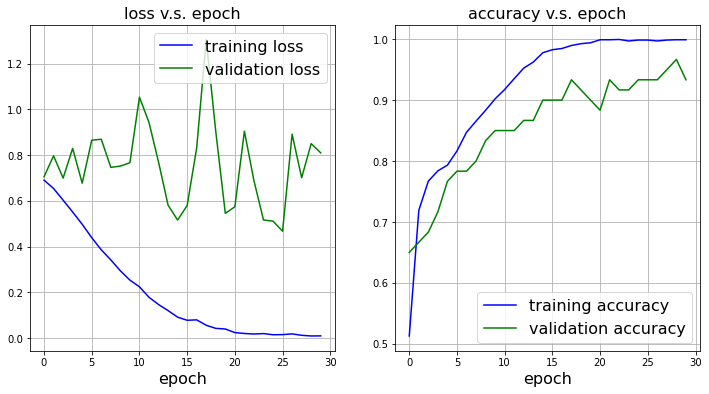

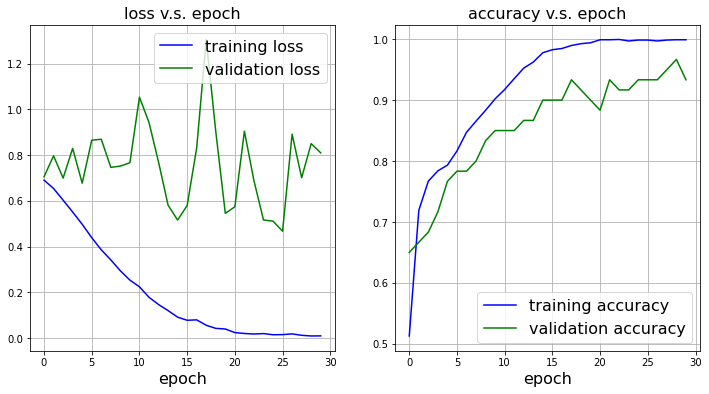

In [37]:
for epoch in range(epoch_save+1, 30):
    t0=time.time()
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    loss_val, acc_val, other_val = test(model, device, loader_val)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)   
    t1=time.time()
    print("time cost", t1-t0)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list, 
              loss_val_list, acc_val_list, other_val)
    save_checkpoint('CNN_TL_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch
    #------- show result ----------------------
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list, 
                          loss_val_list, acc_val_list)
    display.display(fig)

(<Figure size 864x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'loss v.s. epoch'}, xlabel='epoch'>,
        <AxesSubplot:title={'center':'accuracy v.s. epoch'}, xlabel='epoch'>],
       dtype=object))

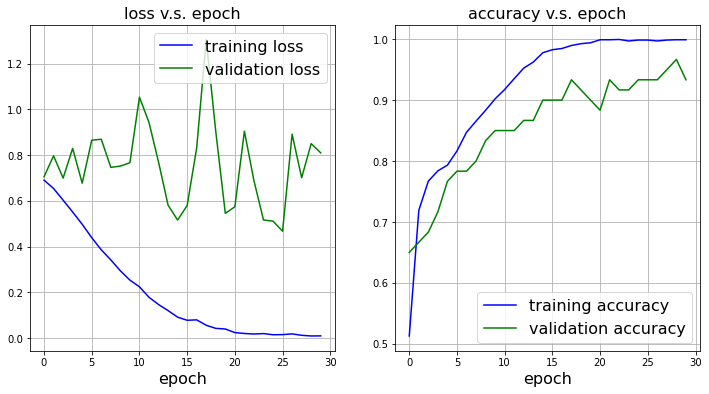

In [38]:
plot_result(loss_train_list, acc_train_list, 
            loss_val_list, acc_val_list)

In [39]:
best_id= np.array(acc_val_list).argmax()
best_id

28

In [40]:
epoch_save=best_id
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint=torch.load('CNN_TL_Pytorch_epoch'+str(epoch_save)+'.pt', map_location=device)
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval() 
#
optimizer = optim.SGD(model.get_trainable_parameters(), lr=0.0001, momentum=0.99) 
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#
(loss_train_list, acc_train_list, 
 loss_val_list, acc_val_list, other_val) = checkpoint['result']   

In [41]:
loss_val, acc_val, (Confusion, Acc, Sens, Prec) = test(model, device, loader_val)
Confusion_sens=Confusion.copy()
for n in range(0, 2):
    Confusion_sens[n,:]/=np.sum(Confusion[n,:])
Confusion_prec=Confusion.copy()
for n in range(0, 2):
    Confusion_prec[:,n]/=np.sum(Confusion[:,n])
print('Accuracy (average)', acc_val)
print('Accuracy (average)', Acc)
print('Sensitivity', Sens)
print('Precision', Prec)
print('Confusion_sens \n', Confusion_sens)
print('Confusion_prec \n', Confusion_prec)

/var/folders/8k/1knn1hln20j8lm_mcv4jv_0w0000gn/T/ipykernel_65260/3373153574.py:33: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Accuracy (average) 0.9666666666666667
Accuracy (average) 0.9666666666666667
Sensitivity [0.93333333 1.        ]
Precision [1.     0.9375]
Confusion_sens 
 [[0.93333333 0.06666667]
 [0.         1.        ]]
Confusion_prec 
 [[1.     0.0625]
 [0.     0.9375]]


In [1]:
#grad cam

In [23]:
model = Net()
model

Net(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [25]:
class ClassifierOutputTarget:
    def __init__(self):
        pass
    def __call__(self, model_output):        
        return model_output.sum()

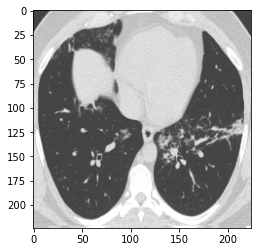

In [50]:
#load a single rgb image from harddrive
image_gray = skimage.io.imread('/Users/bhuvanavenkatappa/Documents/ML notes/hw5s-2/S224/COVID/Covid (62).png')
image_gray = image_gray.reshape(224,224,1)
image = np.concatenate([image_gray, image_gray, image_gray], axis=2)
image=image.astype("float32")
image=image/image.max()
plt.imshow(image)

In [51]:
# Select the target layers from the model
target_layers = [model.resnet50.layer4[-1]]

In [52]:
image_input=torch.tensor(image).permute(2,0,1).view(1,3,224,224)

In [53]:
# Develop the CAM object
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
#targets = None
targets = [ClassifierOutputTarget()]
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam.shape

(1, 224, 224)

In [54]:
grayscale_cam=grayscale_cam[0]
grayscale_cam.shape

(224, 224)

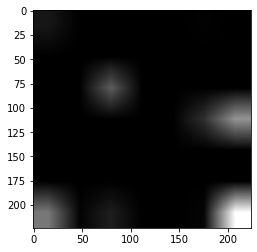

In [55]:
plt.imshow(grayscale_cam, cmap='gray')

In [56]:
# In this example grayscale_cam has only one image in the batch:
cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)

In [57]:
cam_image.shape

(224, 224, 3)

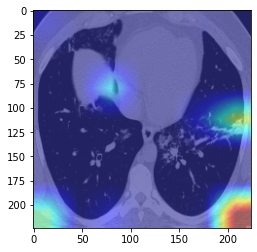

In [58]:
plt.imshow(cam_image)

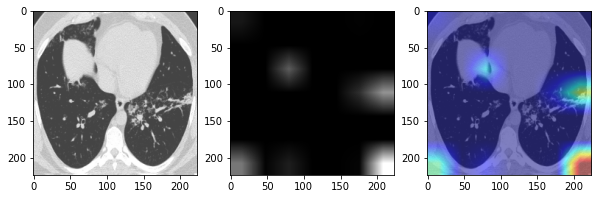

In [59]:
#GradCAM
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget()]
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)

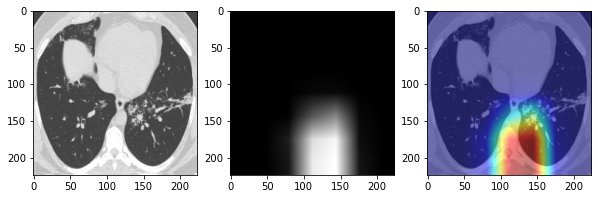

In [60]:
#EigenCAM
cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget()]
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)